<img src="../images/pokeball.png" width="100" align="right">

# Visualization of the<br> Favorite Pok&eacute;mon Survey Results
---
In this notebook, I will generate different visualizations of the [Favorite Pok&eacute;mon Survey](<https://www.reddit.com/r/pokemon/comments/c04rvq/survey_testing_the_every_pok%C3%A9mon_is_someones/>) results. The data was collected and made public by [reddit user mamamia1001](https://www.reddit.com/user/mamamia1001/). Full credit goes to him/her. I am just making those numbers look a bit prettier. For more info, take a look at the [README file](../README.md). Let's get started.


# Preliminaries
First, let's import all the relevant packages, configure some plotting options, and define some basic (path) variables.

In [77]:
%matplotlib inline

import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import pathlib

In [78]:
mpl.rcParams['font.sans-serif'] = "Calibri"
mpl.rcParams['font.family'] = "sans-serif"
#sns.set(font_scale=1.75)
#sns.set_style('ticks')
plt.rc('axes.spines', top=False, right=False)

In [ ]:
# Define paths.
PATH_DATA = pathlib.Path(r'../data')

# Read data
I [downloaded a copy](../data) of the [original results](https://docs.google.com/spreadsheets/d/1c16Wh4AawHGbTi3Eq1DGZQdM4FMUlJO1YwXJZ_ylRvg/edit#gid=557303698) as an Excel file. Let's read just the relevant parts:

In [62]:
df_raw = pd.read_excel(PATH_DATA/'responses.xlsx', sheet_name='Form Responses 1')
df_raw.rename(columns={'Timestamp':'timestamp', 'What is your favourite Pokémon?':'vote'}, inplace=True)

# Remove any potential NaN.
df_raw.dropna(inplace=True)

df_raw.head(3)

,timestamp,vote
0,2019-06-13 13:02:02.242,Munchlax
1,2019-06-13 12:44:00.726,Type-Null
2,2019-06-13 12:44:45.607,Giratina


In [63]:
df = pd.read_excel(PATH_DATA/'responses.xlsx', sheet_name='Results', usecols='A:B')
df.rename(columns={'Results in full':'name', 'Unnamed: 1':'votes'}, inplace=True)

# Remove any potential NaN.
df.dropna(inplace=True)

df.head(3)

,name,votes
0,Bulbasaur,710.0
1,Ivysaur,83.0
2,Venusaur,127.0


# Original Results
As a sanity check, let's (re)compute the already reported numbers.

#### Number of valid votes
Original result: 52725

From the raw results:

In [65]:
n_votes = len(df_raw)
print(n_votes)

52725


From the aggregated results:

In [66]:
n_votes = df['votes'].sum()
print(n_votes)

52725.0


#### Average votes per Pok&eacute;mon
Original result: 65

In [172]:
n_pokemon = len(df['name'].unique())
print(n_votes/n_pokemon)

65.17305315203956


#### Paretto analysis
`mamamia1001` also generated a plot of the [Paretto principle](https://en.wikipedia.org/wiki/Pareto_principle) (also known as the 80/20 rule). Originally, it states that roughly 80% of the effects (in this case, votes) come from 20% of the causes (in this case, Pok&eacute;mon). Let's obtain such plot.

First, we sort the Pok&eacute;mon from most to least popular (we need to do so later on, anyhow):

In [67]:
df_sorted = df.sort_values('votes', ascending=False)

Now, let's compute the cumulative sum of votes and their corresponding vote percentage for each Pok&eacute;mon:

In [68]:
df_sorted['votes_cumulative'] = df_sorted['votes'].cumsum()
df_sorted['votes_cumulative_perc'] = (df_sorted['votes_cumulative']/n_votes) * 100

We just need to generate a few auxiliary variables to generate the plot:

In [164]:
df_sorted['pokemon_perc'] = (np.arange(1, n_pokemon+1)/n_pokemon)*100

# Find the index of the Pokemon corresponding to the 20% of the Pokemon.
index_pokemon_20 = abs(df_sorted['pokemon_perc'] - 20).idxmin()

# Find the index and value of the Pokemon corresponding to the 80% of the votes.
pokemon_votes_80_idx = abs(df_sorted['votes_cumulative_perc'] - 80).idxmin()
pokemon_votes_80 = df_sorted.loc[pokemon_votes_80_idx, 'pokemon_perc']

# Find the index and value of the votes corresponding to the 20% of the Pokemon
votes_pokemon_20_idx = abs(df_sorted['pokemon_perc'] - 20).idxmin()
votes_pokemon_20 = df_sorted.loc[votes_pokemon_20_idx, 'votes_cumulative_perc']

# Find the index of the votes corresponding to the 80% of the votes.
index_votes_80 = abs(df_sorted['votes_cumulative_perc'] - 80).idxmin()


Actually generate the Paretto plot:

Text(0,0.5,'Vote %')

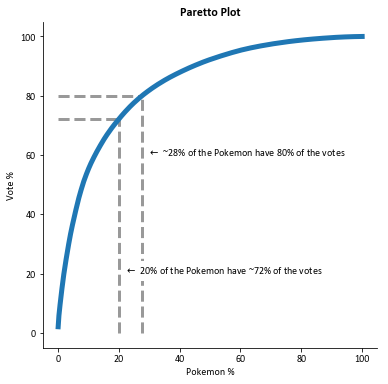

In [171]:
fig, ax = plt.subplots(1, 1, figsize=[6, 6])
ax.plot(df_sorted['pokemon_perc'], df_sorted['votes_cumulative_perc'], linewidth=5)

plt.hlines(80, 0, pokemon_votes_80, linewidth=3, linestyles='dashed', colors=[0.6, 0.6, 0.6])
plt.hlines(votes_pokemon_20, 0, df_sorted.loc[index_pokemon_20, 'pokemon_perc'], linewidth=3, linestyles='dashed', colors=[0.6, 0.6, 0.6])

plt.vlines(20, 0, df_sorted.loc[index_pokemon_20, 'votes_cumulative_perc'], linewidth=3, linestyles='dashed', colors=[0.6, 0.6, 0.6])
plt.vlines(df_sorted.loc[index_votes_80, 'pokemon_perc'], 0, df_sorted.loc[index_pokemon_80, 'votes_cumulative_perc'], linewidth=3, linestyles='dashed', colors=[0.6, 0.6, 0.6])

plt.text(22, 20, r"$\leftarrow$ 20% of the Pokemon have ~{0:.0f}% of the votes".format(votes_pokemon_20), backgroundcolor='w')
plt.text(pokemon_votes_80+2, 60, r"$\leftarrow$ ~{0:.0f}% of the Pokemon have 80% of the votes".format(pokemon_votes_80), backgroundcolor='w')

ax.set_title("Paretto Plot", fontweight='bold')
ax.set_xlabel("Pokemon %")
ax.set_ylabel("Vote %")

# Additional Visualizations
Alright, time to go to uncharted territory. 